<a href="https://colab.research.google.com/github/hemantraghavan/hemantraghavan/blob/main/Hemant_3D_Heart_Heuristic_STL_3D_mesh_improved_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 21.6 MB/s eta 0:00:00
Mounted at /content/drive
Found 256 DICOM files


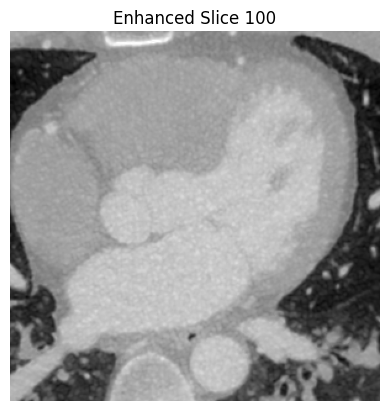

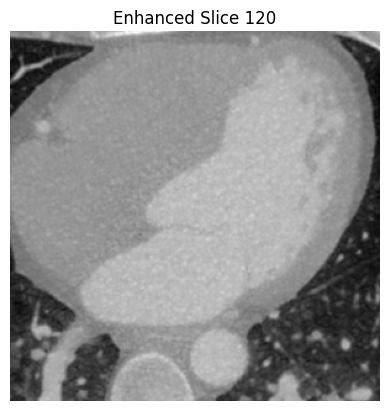

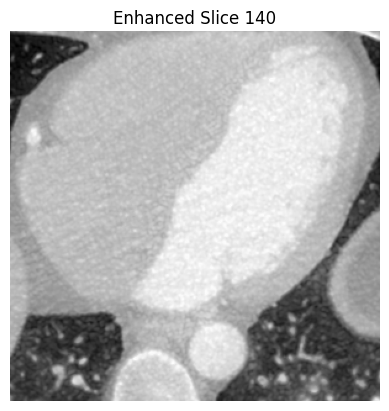

Voxel spacing used: [0.625, 0.488281, 0.488281]
✅ Preview saved to: anatomy_mesh_preview_colored.png
✅ Saved: heart.stl
✅ Saved: ribs.stl
✅ Saved: vessels.stl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🎞️ STEP 1: Install dependencies
!pip install -q pydicom scikit-image matplotlib pyvista opencv-python

# 📂 STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 3: Imports
import os, glob
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure, measure
import pyvista as pv
import cv2
from scipy.ndimage import binary_closing, gaussian_filter, zoom

# 🧠 STEP 4: Enhanced multi-feature segmentation (heart, ribs, vessels)
def segment_anatomy_from_dicom(dicom_path, debug=False, slice_idx=0):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-5)

    # Center crop
    h, w = image.shape
    crop_size = 300
    cx, cy = w // 2, h // 2
    image = image[cy - crop_size // 2:cy + crop_size // 2,
                  cx - crop_size // 2:cx + crop_size // 2]

    # Light CLAHE
    image_eq = exposure.equalize_adapthist(image, clip_limit=0.005)

    # Edge + vesselness
    edges = filters.sobel(image_eq)
    vesselness = filters.meijering(image_eq)
    combined = 0.7 * image_eq + 0.2 * edges + 0.1 * vesselness
    combined = np.clip(combined, 0, 1)

    if debug and slice_idx in [100, 120, 140]:
        plt.imshow(combined, cmap='gray')
        plt.title(f"Enhanced Slice {slice_idx}")
        plt.axis('off')
        plt.savefig(f"combined_slice_{slice_idx}.png")
        plt.show()

    # Threshold + morphology
    thresh = filters.threshold_otsu(combined)
    binary = combined > thresh
    binary = morphology.remove_small_objects(binary, min_size=500)
    binary = morphology.remove_small_holes(binary, area_threshold=500)
    binary = morphology.binary_closing(binary, morphology.disk(2))

    # Label filter
    labeled = measure.label(binary)
    props = measure.regionprops(labeled)

    keep_labels = []
    for r in props:
        if r.area > 800 and r.eccentricity < 0.995 and r.extent < 0.95 and r.solidity > 0.3:
            keep_labels.append(r.label)

    mask = np.zeros_like(labeled)
    for label_val in keep_labels:
        mask[labeled == label_val] = label_val

    if debug and slice_idx in [100, 120, 140]:
        plt.imsave(f"mask_slice_{slice_idx}.png", mask, cmap='nipy_spectral')

    return mask.astype(np.uint8)

# 📁 STEP 5: DICOM folder path
dicom_folder = "/content/drive/MyDrive/Third_Case/Third_Case/DICOM/EXP00000_256"

# 🔁 STEP 6: Segment all slices
dicom_files = sorted(glob.glob(os.path.join(dicom_folder, "*")))
print(f"Found {len(dicom_files)} DICOM files")

mask_volume = []
for i, dcm_path in enumerate(dicom_files):
    try:
        mask = segment_anatomy_from_dicom(dcm_path, debug=True, slice_idx=i)
        mask_volume.append(mask)
    except Exception as e:
        print(f"❌ Slice {i} failed: {e}")

if len(mask_volume) == 0:
    raise RuntimeError("No valid segmentations. Please check DICOM input and filters.")

mask_volume = np.stack(mask_volume, axis=0)

# 📐 STEP 7: Voxel spacing
ds = pydicom.dcmread(dicom_files[0])
spacing = [float(ds.SliceThickness)] + [float(ds.PixelSpacing[0])] * 2
print(f"Voxel spacing used: {spacing}")

# ✨ STEP 8: 3D Volume smoothing and interpolation
binary_volume = (mask_volume > 0).astype(np.uint8)
closed_volume = binary_closing(binary_volume, structure=np.ones((3,3,3)))
smoothed_volume = gaussian_filter(closed_volume.astype(np.float32), sigma=1)
interpolated_volume = zoom(smoothed_volume, zoom=1.5, order=1)

# 🧱 STEP 9: Mesh generation with color & STL export
unique_labels = np.unique(mask_volume)
unique_labels = unique_labels[unique_labels != 0]
color_meshes = []
label_names = {1: "Heart", 2: "Ribs", 3: "Vessels"}
label_colors = {1: (220, 20, 60), 2: (255, 255, 255), 3: (65, 105, 225)}
label_opacity = {1: 0.9, 2: 0.5, 3: 0.7}

for label_id in unique_labels:
    binary_label = (mask_volume == label_id).astype(np.uint8)
    closed_label = binary_closing(binary_label, structure=np.ones((3,3,3)))
    smoothed_label = gaussian_filter(closed_label.astype(np.float32), sigma=1)
    upsampled = zoom(smoothed_label, zoom=1.5, order=1)
    verts, faces, _, _ = measure.marching_cubes(upsampled, level=0.3, spacing=np.array(spacing)*np.array([1.0,1.5,1.5]))
    faces = np.reshape(faces, (-1, 3))
    poly = pv.PolyData(verts, np.hstack([np.full((faces.shape[0], 1), 3), faces]))
    poly = poly.decimate(0.4)
    poly.clean(inplace=True)
    poly = poly.extract_surface()
    color = label_colors.get(label_id, (200, 200, 200))
    opacity = label_opacity.get(label_id, 0.6)
    label = label_names.get(label_id, f"Region {label_id}")
    color_meshes.append((poly, color, label, opacity))

# 🗄️ STEP 10: Render and save preview
preview_path = "anatomy_mesh_preview_colored.png"
plotter = pv.Plotter(off_screen=True, window_size=(800, 800))
plotter.set_background("white")

for mesh, color, label, opacity in color_meshes:
    plotter.add_mesh(mesh, color=np.array(color) / 255.0, opacity=opacity,
                     smooth_shading=True, specular=0.6, specular_power=25, name=label)
    plotter.add_point_labels([mesh.center], [label], font_size=12, text_color="black")

plotter.enable_eye_dome_lighting()
plotter.add_axes()
plotter.show(screenshot=preview_path)
print(f"✅ Preview saved to: {preview_path}")

# 🗓️ STEP 11: Save STL per label
for i, (mesh, _, label, _) in enumerate(color_meshes):
    filename = f"{label.replace(' ', '_').lower()}.stl"
    mesh.save(filename)
    print(f"✅ Saved: {filename}")

# 🖖 STEP 12: Download preview and STL files
from google.colab import files
files.download(preview_path)
for _, _, label, _ in color_meshes:
    files.download(f"{label.replace(' ', '_').lower()}.stl")
